In [4]:
import pandas as pd
import string
import numpy as np
import json

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)

In [5]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [6]:
# Load all the dataset
df1 = pd.read_csv("./data/USvideos.csv")
df2 = pd.read_csv("./data/CAvideos.csv")
df3 = pd.read_csv("./data/GBvideos.csv")

In [7]:
#load the datasets containing the category names
data1 = json.load(open('./data/US_category_id.json'))
data2 = json.load(open('./data/CA_category_id.json'))
data3 = json.load(open('./data/GB_category_id.json'))


In [10]:
def category_extractor(data):
    i_d = [data['items'][i]['id'] for i in range(len(data['items']))]
    title = [data['items'][i]['snippet']["title"] for i in range(len(data['items']))]
    i_d = list(map(int, i_d))
    category = zip(i_d, title)
    category = dict(category)
    return category

#create a new category column by mapping the category names to their id
df1['category_title'] = df1['category_id'].map(category_extractor(data1))
df2['category_title'] = df2['category_id'].map(category_extractor(data2))
df3['category_title'] = df3['category_id'].map(category_extractor(data3))

#join the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

#drop rows based on duplicate videos
df = df.drop_duplicates('video_id')

#collect only titles of entertainment videos
#feel free to use any category of video that you want
entertainment = df[df['category_title'] == 'Entertainment']['title']
print(entertainment.head())
entertainment = entertainment.tolist()

1     The Trump Presidency: Last Week Tonight with J...
3                      Nickelback Lyrics: Real or Fake?
4                              I Dare You: GOING BALD!?
6             Roy Moore & Jeff Sessions Cold Open - SNL
11    (SPOILERS) 'Shiva Saves the Day' Talked About ...
Name: title, dtype: object


In [26]:
!pip3 install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 7.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


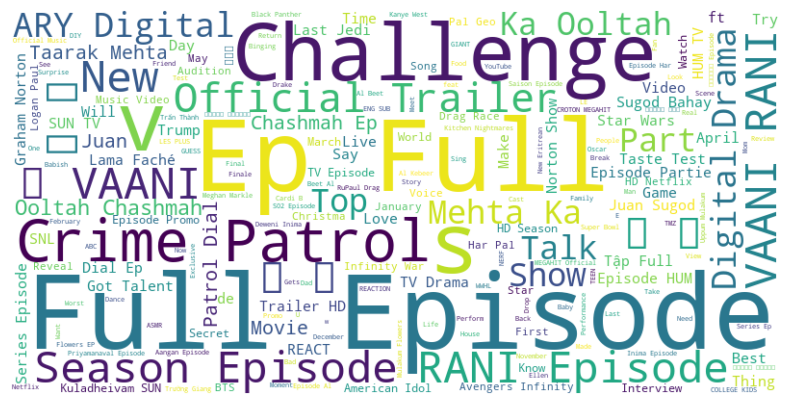

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'entertainment' is a list of titles
# Concatenate all titles into a single string
entertainment_text = ' '.join(entertainment)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(entertainment_text)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [11]:
#remove punctuations and convert text to lowercase
def clean_text(text):
    text = ''.join(e for e in text if e not in string.punctuation).lower()
    
    text = text.encode('utf8').decode('ascii', 'ignore')
    return text

corpus = [clean_text(e) for e in entertainment]

In [12]:
tokenizer = Tokenizer()
def get_sequence_of_tokens(corpus):
  #get tokens
  tokenizer.fit_on_texts(corpus)
  total_words = len(tokenizer.word_index) + 1
 
  #convert to sequence of tokens
  input_sequences = []
  for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequences.append(n_gram_sequence)
 
  return input_sequences, total_words
inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[1, 88],
 [1, 88, 4064],
 [1, 88, 4064, 70],
 [1, 88, 4064, 70, 368],
 [1, 88, 4064, 70, 368, 1313],
 [1, 88, 4064, 70, 368, 1313, 11],
 [1, 88, 4064, 70, 368, 1313, 11, 137],
 [1, 88, 4064, 70, 368, 1313, 11, 137, 1087],
 [1, 88, 4064, 70, 368, 1313, 11, 137, 1087, 1603],
 [6138, 1432]]

In [13]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)


In [14]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 10)            139150    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 13915)             1405415   
                                                                 
Total params: 1588965 (6.06 MB)
Trainable params: 1588965 (6.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history =model.fit(predictors, label, epochs=30, verbose=5).history

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


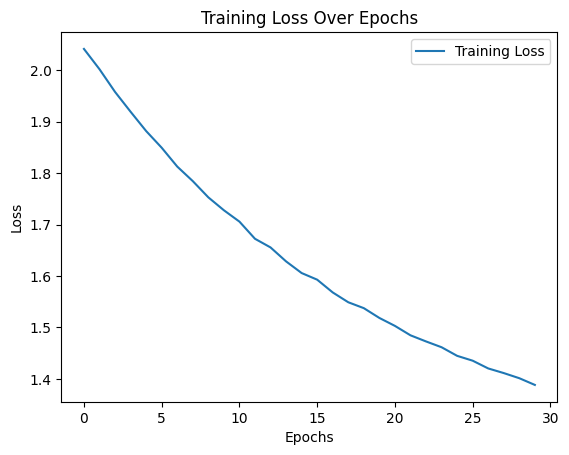

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' contains loss values from model fitting
loss = history['loss']  # Extracting loss values from history

# Plotting the loss
plt.plot(loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        
        predicted_index = np.argmax(predicted)  # Find the index of the word with the highest probability
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text.title()

In [17]:
print (generate_text("korea", 4, model, max_sequence_len))


Korea 2 Series 2018 Ending


In [30]:
print (generate_text("crime petrol", 7, model, max_sequence_len))


Crime Petrol Patrol Dial 100 Ep 728 Full Episode


In [31]:
print (generate_text("Digital", 7, model, max_sequence_len))


Digital Exclusive Season Finale The Robert Prince God


In [32]:
print (generate_text("Top", 5, model, max_sequence_len))


Top 10 Most Cringeworthy Of 2017


In [33]:
print (generate_text("Talent", 5, model, max_sequence_len))


Talent Episode 16 Teaser 10 Har
